In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib widget

import sys
sys.path.append("../src/")
import hb_dic, fft_utils

# Single Watershed Analysis

## Load Data and Preprocessing

Hubbard Brook weekly stream chemistry DIC data (Unit: mmol/L)

Data is available for W6 from 01/03/1994, and for other watersheds W1~W9 from 05/28/1996

Data for HBK(?) is available in a monthly resolution from 06/17/1996, so does W101(?) but from 07/14/1997, and ML70(?) with a weekly resolution from 06/03/2013

In [2]:
watershed = "W{}".format(
    2
)  # take watershed 2 as an example because the data quality is good
DIC = hb_dic.load_DIC_series(watershed)

## Plot Original Time Series

Blue line is the series, and red traiangles are NaN values.

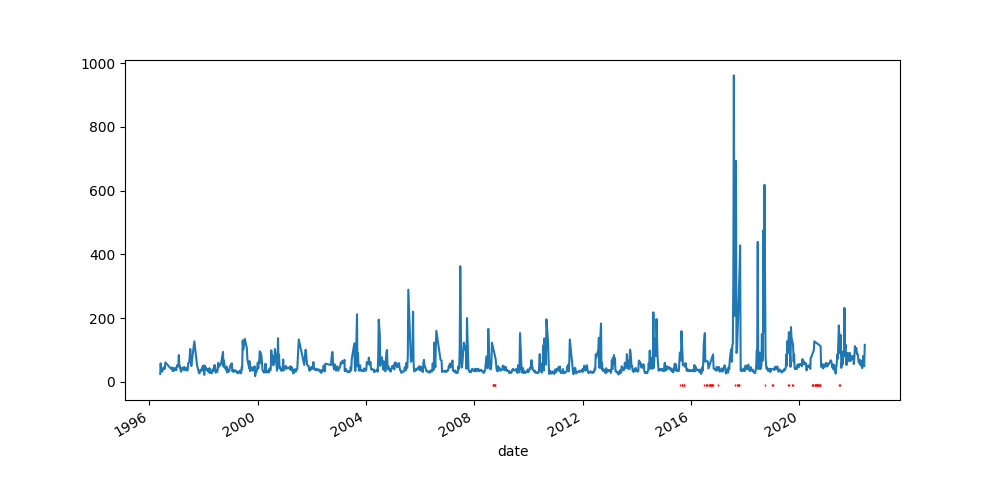

In [3]:
plt.figure(figsize=(10, 5))
DIC_plot = hb_dic.SeriesPlotWithMissingValues(DIC)
DIC_plot.plot()

## Plot Resampled Weekly Time Series

Blue line is the series, and red traiangles are NaN values.


    Length of the series: 1358
    Number of missing values: 182
    


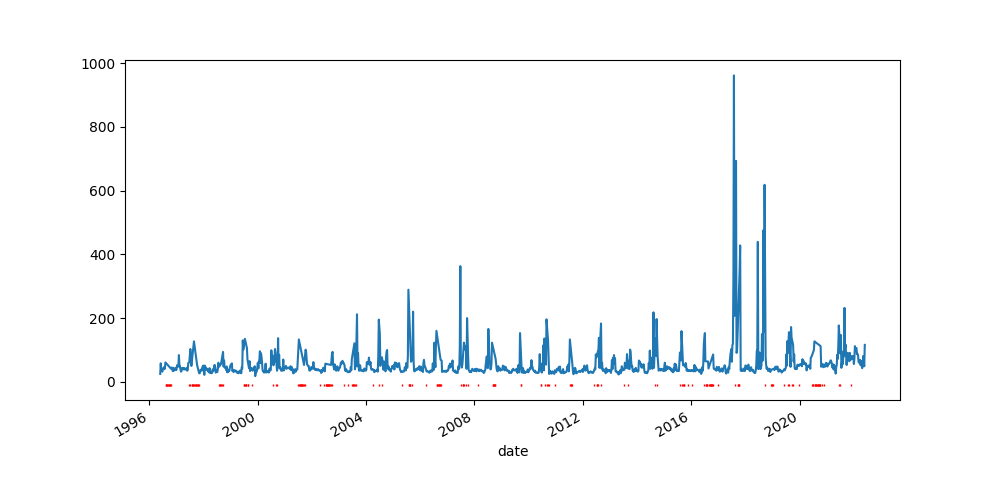

In [4]:
DIC_resampled = DIC.resample("W-MON", closed="left", label="left").mean()
plt.figure(figsize=(10, 5))
DIC_resampled_plot = hb_dic.SeriesPlotWithMissingValues(DIC_resampled)
DIC_resampled_plot.plot()
print(
    """
    Length of the series: {}
    Number of missing values: {}
    """.format(
        len(DIC_resampled_plot.data), len(DIC_resampled_plot.missing)
    )
)

## Fourier Transformation

Fourier power spectrum, largest peak at about one year, which means the annual cycle is the dominant component.

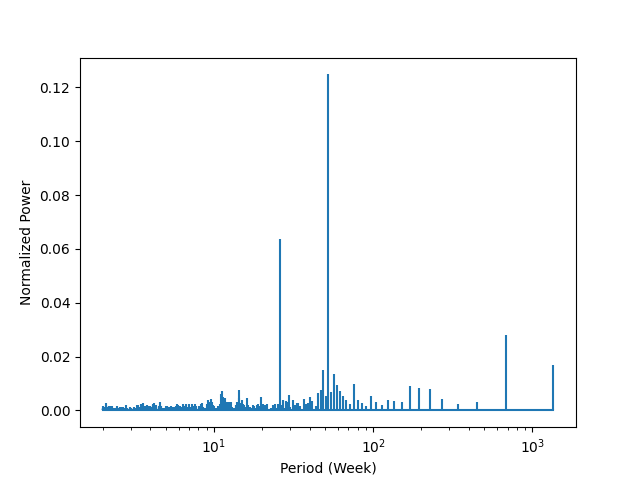

In [5]:
DIC_filled = DIC_resampled.interpolate()  # fill missing data
power_specturm = fft_utils.spectrum(DIC_filled)
plt.figure()
power_specturm_plot = fft_utils.FourierSpectrumPlot(power_specturm)
power_specturm_plot.plot()

# Compare Watersheds

## Preparations

### Load Data and Save as Dicts

In [2]:
watershed_list = ["W{}".format(i + 1) for i in range(9)]
data_dict = hb_dic.load_watershed_data(watershed_list, ["DIC", "pH"])

### Initialize Resampled DIC

In [7]:
DIC_resampled_dict = {}
for i in range(9):
    watershed = "W{}".format(i + 1)
    DIC: pd.Series = data_dict[watershed]["DIC"]
    DIC_resampled_dict[watershed] = DIC.resample(
        "W-MON", closed="left", label="left"
    ).mean()

### Plot Params

In [3]:
nrows = 3
ncols = 3
figsize = (16, 12)

## pH Check

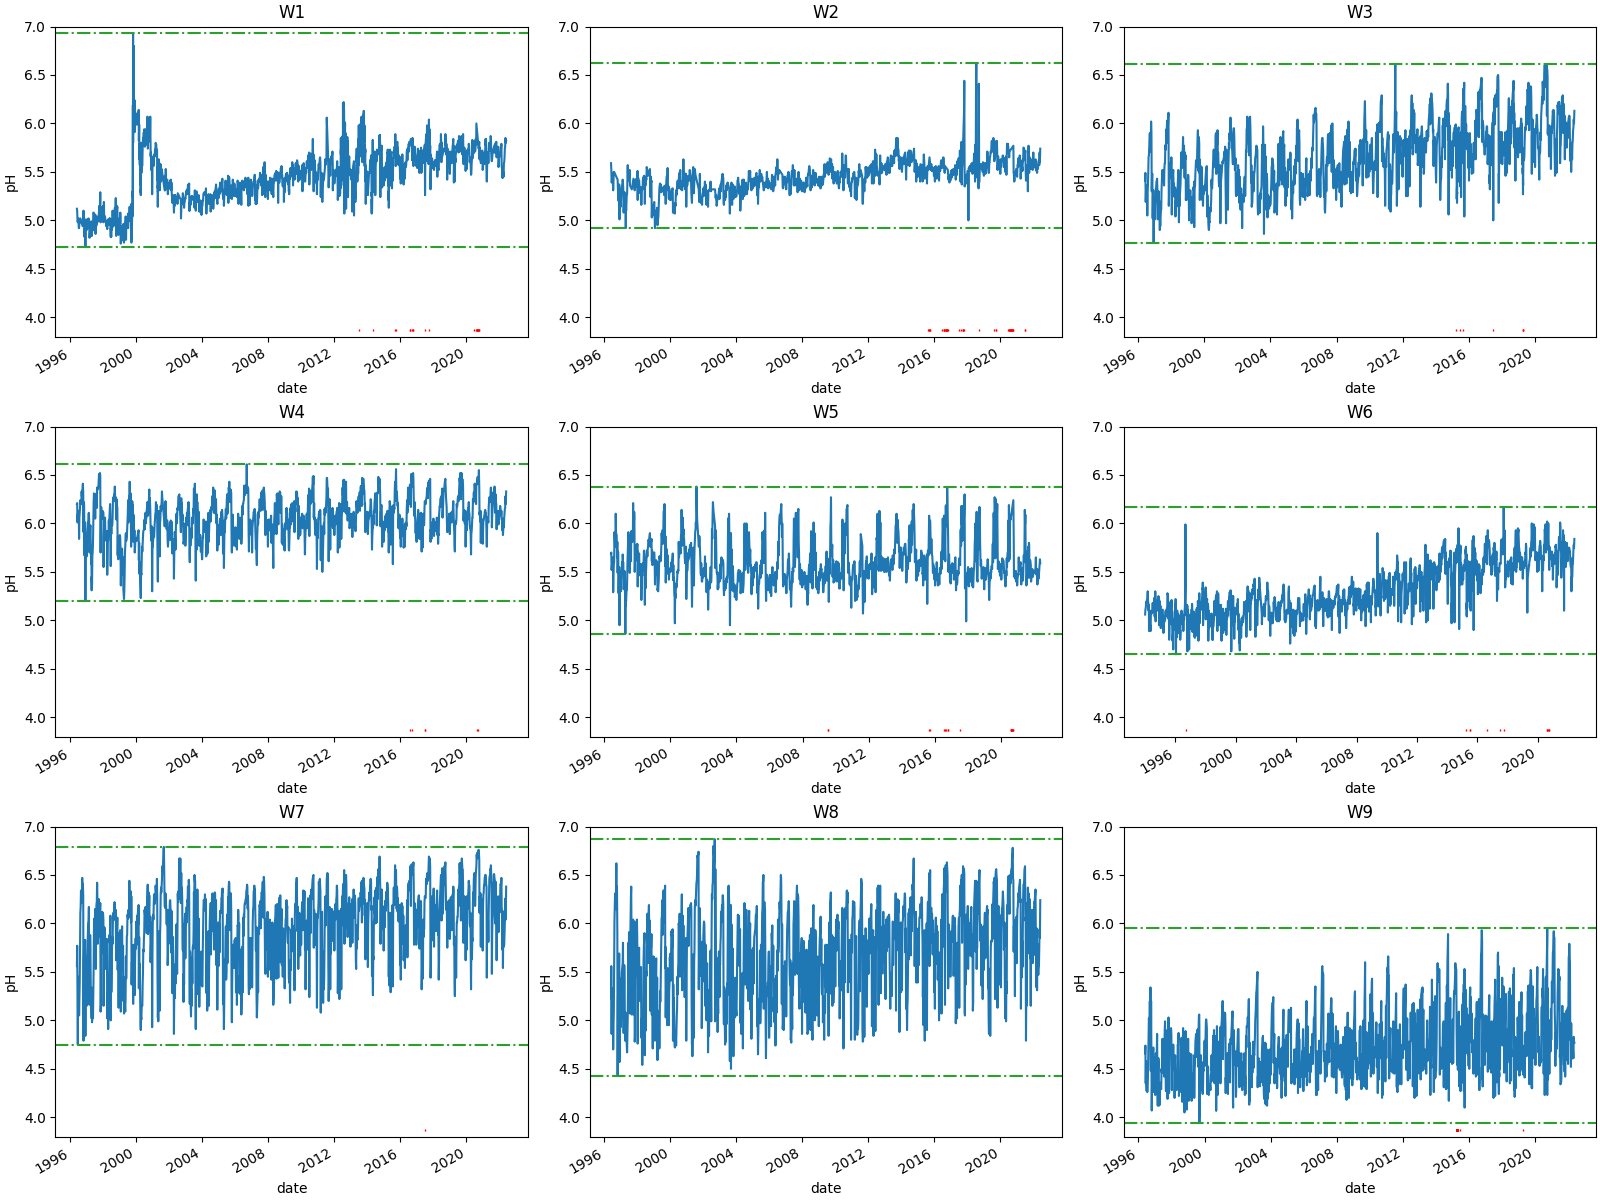

In [21]:
pH_fig, pH_axs = plt.subplots(
    nrows, ncols, figsize=figsize, constrained_layout=True, subplot_kw={"ylabel": "pH"}
)
for i in range(9):
    watershed = "W{}".format(i + 1)
    pH: pd.Series = data_dict[watershed]["pH"]

    plt.sca(pH_axs.flat[i])
    plt.ylim(3.8, 7.0)
    pH_plot = hb_dic.SeriesPlotWithMissingValues(pH)
    pH_plot.plot()

    pH_min, pH_max = pH.min(), pH.max()
    hline_fmt = {"color": "C2", "linestyle": "-."}
    plt.axhline(pH.min(), **hline_fmt)
    plt.axhline(pH.max(), **hline_fmt)

    plt.title(watershed)

## Resampled DIC Plot

### Plot DIC Profile

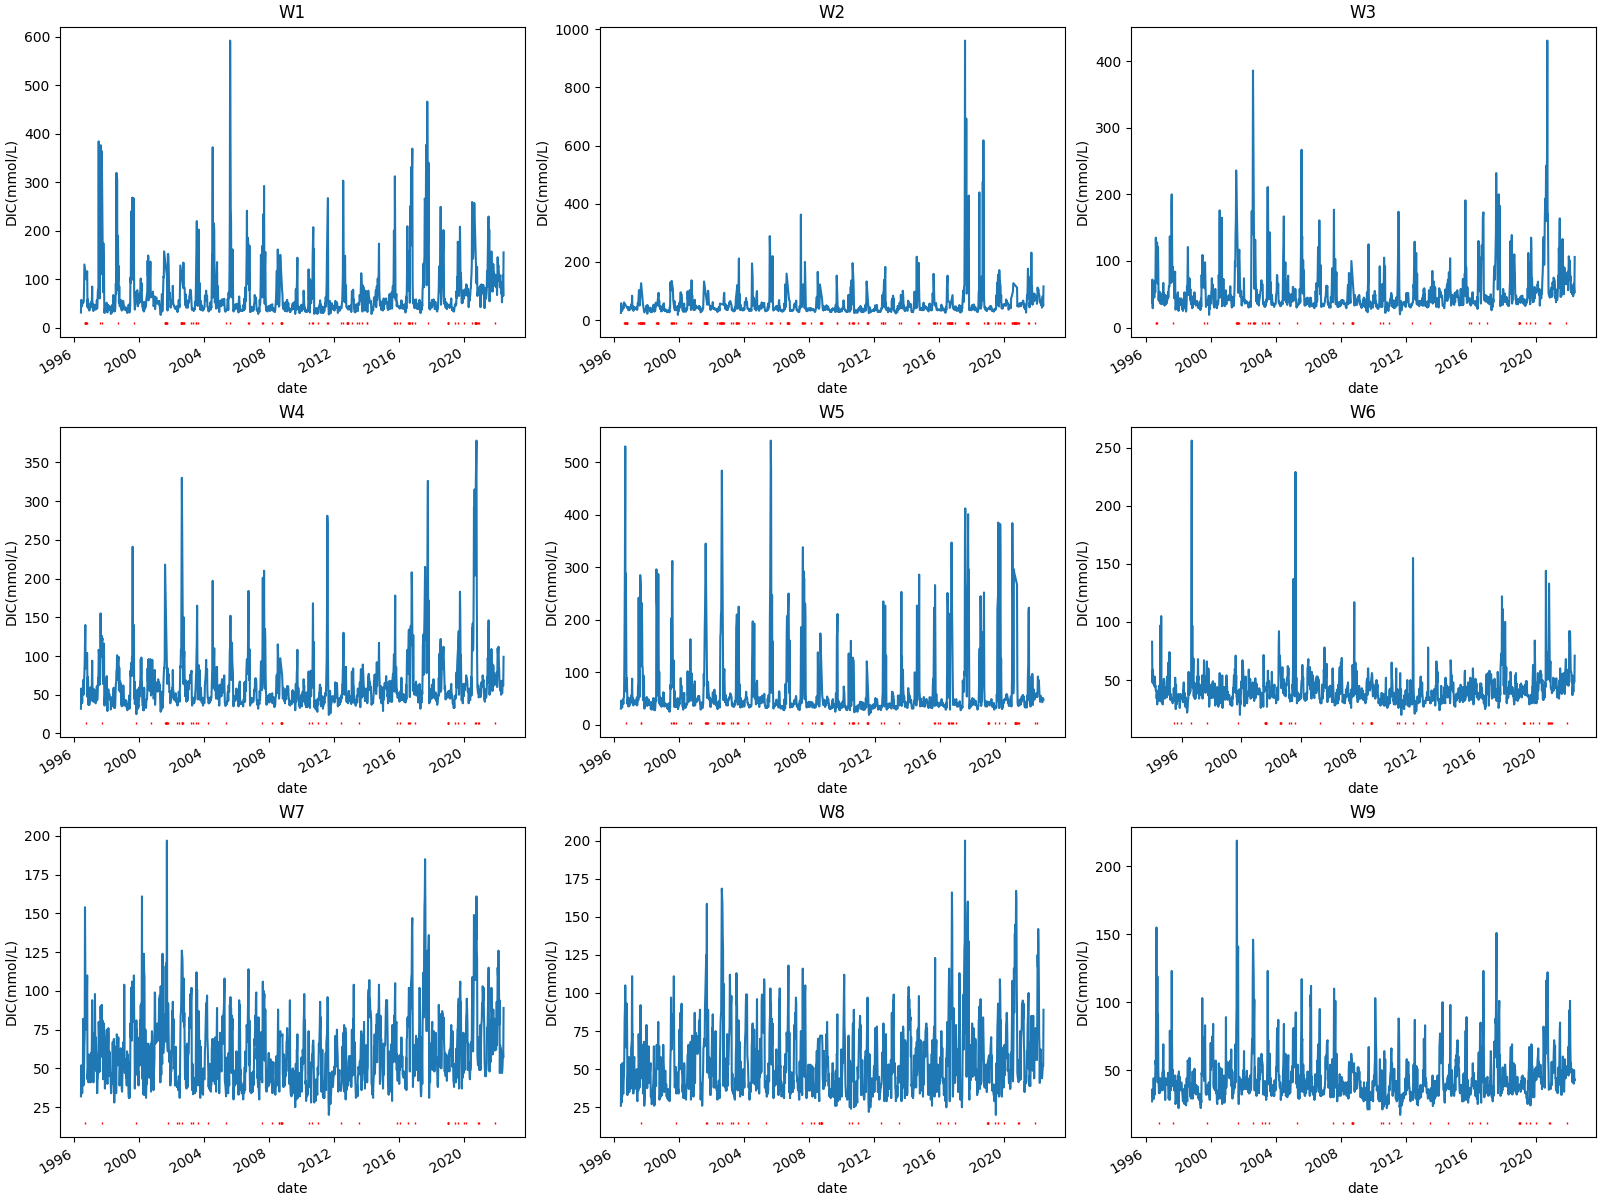

In [8]:
DIC_fig, DIC_axs = plt.subplots(
    nrows,
    ncols,
    figsize=figsize,
    constrained_layout=True,
    subplot_kw={"ylabel": "DIC(mmol/L)"},
)

for i in range(9):
    watershed = "W{}".format(i + 1)
    DIC_resampled: pd.Series = DIC_resampled_dict[watershed]
    plt.sca(DIC_axs.flat[i])
    DIC_resampled_plot = hb_dic.SeriesPlotWithMissingValues(DIC_resampled)
    DIC_resampled_plot.plot()

    plt.title(watershed)

### Plot Missing Ratio of Resampled Data

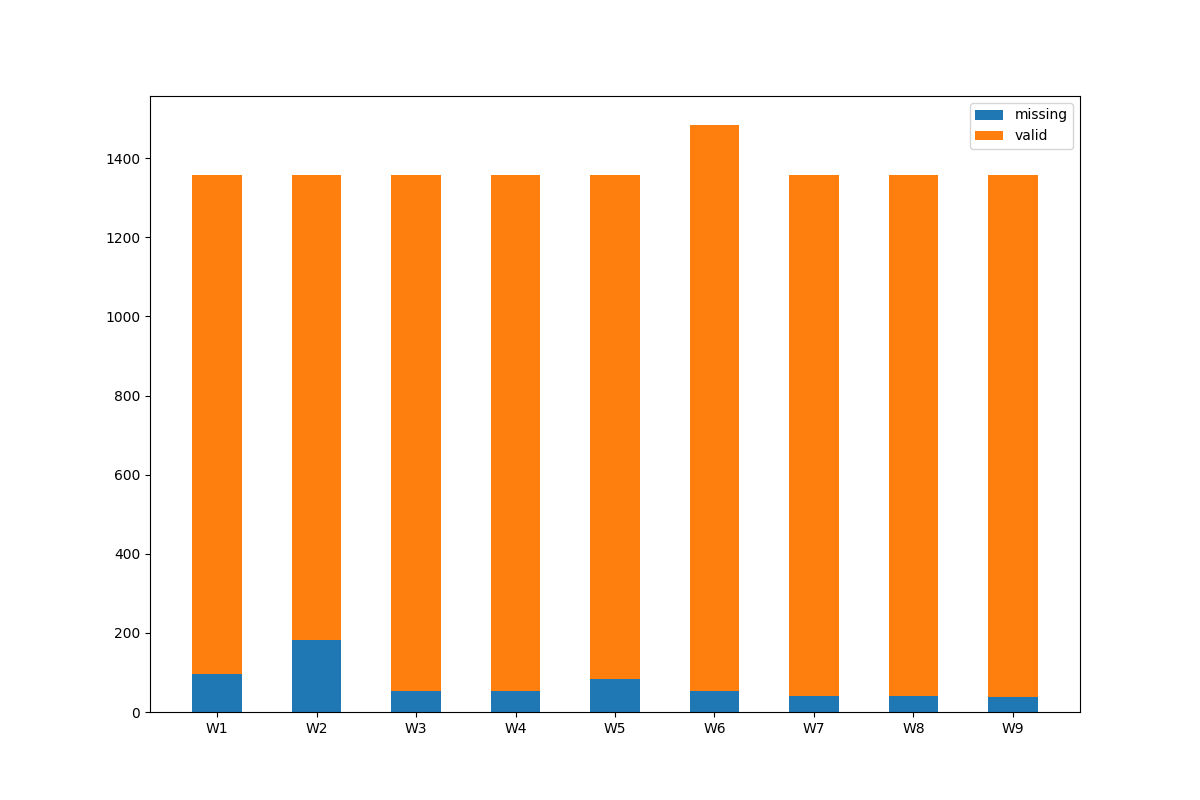

In [10]:
valid_num = []
missing_num = []

for i in range(9):
    watershed = "W{}".format(i + 1)
    DIC_resampled = DIC_resampled_dict[watershed]
    n_total = len(DIC_resampled)
    n_valid = DIC_resampled.count()
    n_missing = n_total - n_valid
    valid_num.append(n_valid)
    missing_num.append(n_missing)

bottom = np.zeros(len(watershed_list))
counts = {
    "missing": np.array(missing_num),
    "valid": np.array(valid_num),
}

plt.figure(figsize=(12, 8))

for validity, count in counts.items():
    plt.bar(watershed_list, count, 0.5, label=validity, bottom=bottom)
    bottom += count

plt.legend()

## Plot Fourier Spectra of DIC

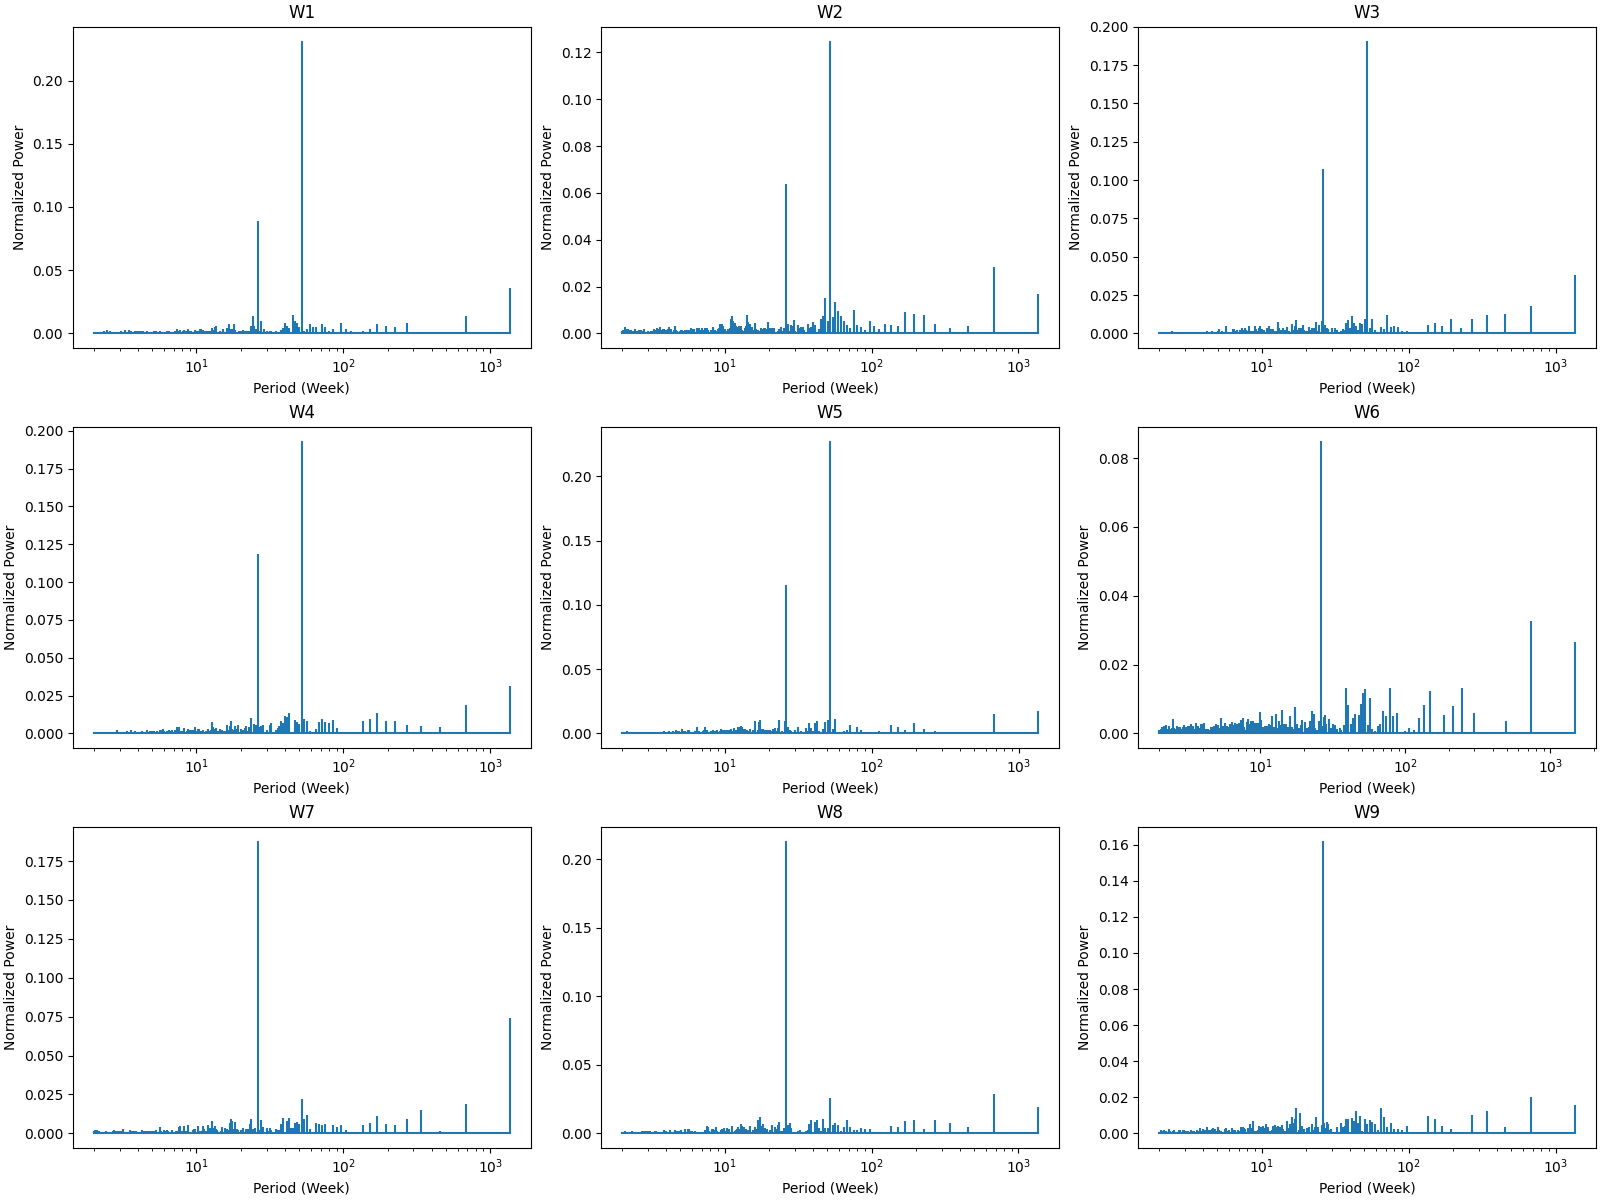

In [13]:
spec_fig, spec_axs = plt.subplots(
    nrows,
    ncols,
    figsize=figsize,
    constrained_layout=True,
)

for i in range(9):
    watershed = "W{}".format(i + 1)
    DIC_filled = DIC_resampled_dict[watershed].interpolate()
    power_specturm = fft_utils.spectrum(DIC_filled)
    plt.sca(spec_axs.flat[i])    
    power_specturm_plot = fft_utils.FourierSpectrumPlot(power_specturm)
    power_specturm_plot.plot()
    plt.title(watershed)